In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from hysteresis.base import BaseHysteresis
from hysteresis.training import train_hysteresis
from hysteresis.visualization import plot_hysteresis_density

In [10]:

fname = f'D:/APS/Q7Hysteresis' \
        f'/APSU_Q7_100017035_MajorHysteresisLoop_0000_000_00_procFld_01.csv'

data = pd.read_csv(fname, skiprows=5)
data = data.drop([0])

# get real h, m
h = torch.tensor(data['Current'].to_numpy(dtype=np.float64))
m = torch.tensor(data['BigB1'].to_numpy(dtype=np.float64))

358
Parameter containing:
tensor([ 1.1248,  0.2990, -0.0905, -0.3420])


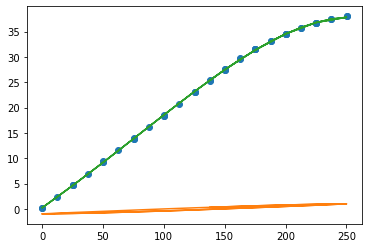

In [11]:
h_train = h.detach()[:50]
m_train = m.detach()[:50]


# fit using normal hysteresis model
H = BaseHysteresis(h_train,
                   m_train,
                   mesh_scale = 0.5,
                   temp=1e-2,
                   polynomial_degree=4,
                   polynomial_fit_iterations=10000)
print(len(H.mesh_points))
print(H.transformer._poly_fit.weights)

fig,ax = plt.subplots()
ax.plot(h_train, m_train,'o')
ax.plot(h_train, H(h_train).detach())
ax.plot(h_train, H.transformer.get_fit(h_train))



tensor(0.0006, dtype=torch.float64)
tensor(0.0006, dtype=torch.float64)
Parameter containing:
tensor([10.3229], requires_grad=True)
Parameter containing:
tensor([11.2088], requires_grad=True)
Parameter containing:
tensor([-19.9207], requires_grad=True)
Parameter containing:
tensor([ 1.1248,  0.2990, -0.0905, -0.3420])


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_20064/41827879.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.min(torch.tensor(loss_trace)))


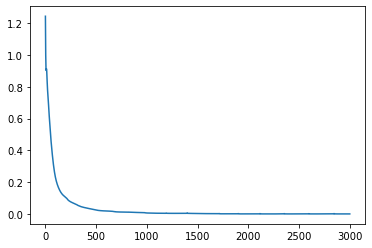

In [12]:
# train on data
loss_trace = train_hysteresis(H, 3000, lr=0.1, atol=1e-8)
fig, ax = plt.subplots()
ax.plot(loss_trace)
print(loss_trace[-1])
print(torch.min(torch.tensor(loss_trace)))
print(H.offset)
print(H.scale)
print(H.slope)
print(H.transformer._poly_fit.weights)

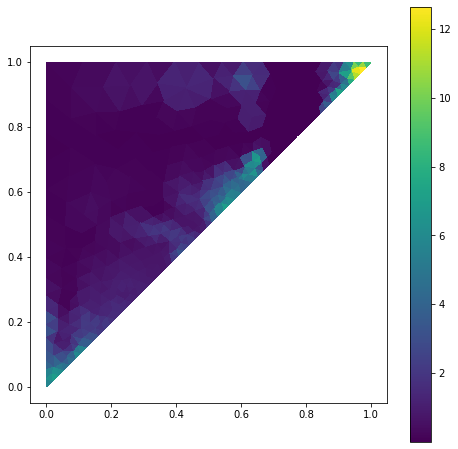

In [13]:
fig, ax = plot_hysteresis_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

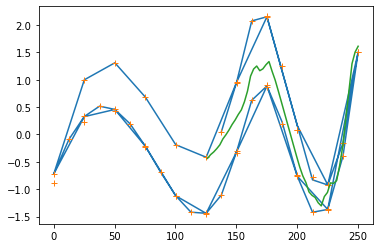

In [17]:
fig, ax = plt.subplots()
m_pred = H(h_train)
m_train_trans = H.transformer.transform(h_train, m_train)[1]
ax.plot(h_train, m_pred.detach())
ax.plot(h_train, m_train_trans,'+')

# compare to future
h_test = torch.linspace(*H.valid_domain,100)[50:]

H.future()
m_future = H(h_test)
ax.plot(h_test, m_future.detach())


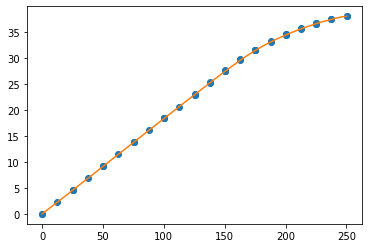

In [19]:
# plot future prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

H.future()

m_future = H(h_test, return_real=True)
ax2.plot(h_train, m_train,'o')
ax2.plot(h_test, m_future.detach())
#ax2.plot(h_train, m_train - fit,'o')

#ax3b = ax3.twinx()
#ax3b.plot(h[n_train:], 'C1')
#print(torch.sqrt(torch.nn.MSELoss()(m_future, m[n_train:])))

In [16]:
#train model using priors and MAP
from hysteresis.bayesian import BayesianHysteresis, positional_covariance
from hysteresis.training import train_bayes

def cov(model):
    return positional_covariance(model, 1.0) * 50.0

bh = BayesianHysteresis(H)
guide, trace = train_bayes(h_train, m_train, bh, 5000)
plt.plot(trace)

AssertionError: 

In [ ]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density
h_test = torch.linspace(0,1.0,100)
bh.future()
pred_summary, samples = predict(h_test, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['mean'].flatten().detach())
)

# plot confidence width
fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['95%'].flatten().detach()) - \
    torch.nn.Softplus()(pred_summary['density']['5%'].flatten().detach())
)

fig, ax = plt.subplots()
ax.plot(h_test, mean.detach())
ax.plot(h_train, m_train,'o')
ax.fill_between(h_test, l, u, alpha=0.25)

fig3, ax3 = plt.subplots()
ax3.plot(pred_summary['obs']['std'])

In [ ]:
fig, ax = plt.subplots()
ax.plot(h_test, mean.detach()*norm_scale.detach() + poly(h_test).detach())